In [1]:
import pandas as pd
import os

In [2]:
pwd

'C:\\Users\\User\\Household-Power-Cosumption-LSTM-master'

In [3]:
data=pd.read_csv("household_power_consumption_mod.csv",header=0,infer_datetime_format=True,parse_dates=['datetime'],index_col=['datetime'])

In [4]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [5]:
daily_data=data.resample('D').sum()

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

F:\anaconda\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


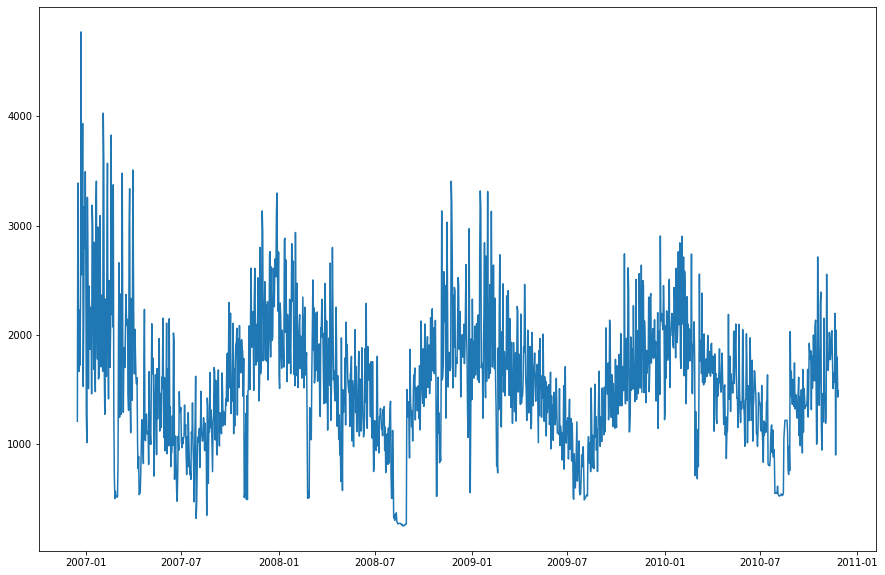

In [7]:
plt.figure(figsize=(15,10))
plt.plot(daily_data['Global_active_power'])

In [8]:
#You may save the CSV file according to the days
daily_data.to_csv("household_daily.csv")

In [12]:
from sklearn.metrics import mean_squared_error

In [13]:
def forecasts(act,pred):
    scores=[]
    for i in range(act.shape[1]):
        mse=mean_squared_error(act[:,i],pred[:,i])
        rmse=np.sqrt(mse)
        scores.append(rmse)
    s=0
    for row in range(act.shape[0]):
        for col in range(act.shape[1]):
            s+=(act[row,col]-pred[row,col])**2
    score=np.sqrt(s/(act.shape[0]*act.shape[1]))
    return score,scores

In [14]:
daily_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011
...,...,...,...,...,...,...,...,...
2010-11-22,2041.536,142.354,345883.85,8660.4,4855.0,2110.0,10136.0,16924.600023
2010-11-23,1577.536,137.450,346428.76,6731.2,1871.0,458.0,7611.0,16352.266679
2010-11-24,1796.248,132.460,345644.59,7559.4,1096.0,2848.0,12224.0,13769.466664


In [15]:
def split(data):
    train,test=data[1:-328],data[-328:-6]
    train=np.array(np.split(train,len(train)/7))
    test=np.array(np.split(test,len(test)/7))
    return train,test

In [16]:
def summarized_scores(name,score,scores):
    s_scores=', '.join(['%.1f'%s for s in scores])
    print('%s:[%.3f] %s'%(name,score,s_scores))

In [17]:
def to_supervized(train,n_in,n_out):
    data=train.reshape((train.shape[0]*train.shape[1],train.shape[2]))
    X,y=[],[]
    in_start=0
    for i in range(len(data)):
        in_end=in_start+n_in
        out_end=in_end+n_out
        if out_end<len(data):
            x_in=data[in_start:in_end,0]
            x_in=x_in.reshape((len(x_in),1))
            X.append(x_in)
            y.append(data[in_end:out_end,0])
        in_start+=1
    return np.array(X),np.array(y)

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

Using TensorFlow backend.


In [19]:
def build_model(train,n_input):
    train_x,train_y=to_supervized(train,n_input,7)
    verbose=0
    epochs=70
    batch_size=16
    n_timesteps=train_x.shape[1]
    n_features=train_x.shape[2]
    n_outputs=train_y.shape[1]
    model=Sequential()
    model.add(LSTM(200,activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse',optimizer='adam')
    model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,verbose=verbose)
    return model

In [20]:
def forecast(model,history,n_input):
    data=np.array(history)
    data=data.reshape((data.shape[0]*data.shape[1],data.shape[2]))
    in_x=data[-n_input:,0]
    in_x=in_x.reshape((1,len(in_x),1))
    yhat=model.predict(in_x,verbose=0)
    return yhat[0]

In [21]:
def evaluate_model(train,test,n_input):
    model=build_model(train,n_input)
    history=[x for x in train]
    prediction=[]
    for i in range(len(test)):
        yhat_s=forecast(model,history,n_input)
        prediction.append(yhat_s)
        history.append(test[i,:])
    prediction=np.array(prediction)
    score,scores=forecasts(test[:,:,0],prediction)
    return score,scores

In [23]:
import numpy as np

In [24]:
train,test=split(daily_data.values)

In [25]:
train.shape

(159, 7, 8)

In [26]:
test.shape

(46, 7, 8)

In [27]:
score,scores=evaluate_model(train,test,14)

In [28]:
summarized_scores('lstm',score,scores)

lstm:[376.477] 405.7, 400.1, 347.3, 361.1, 370.6, 302.8, 432.9


In [29]:
days=['sun','mon','tue','wed','thr','fri','sat']

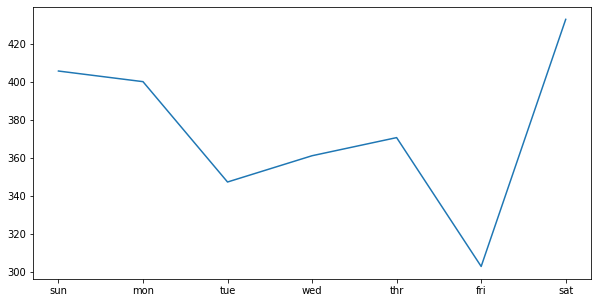

In [30]:
plt.figure(figsize=(10,5))
plt.plot(days,scores)